In [117]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
import pickle
import time

Example notation for API

In [3]:
from dotenv import load_dotenv
import os
from openai import OpenAI
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the environment variables from the .env file
load_dotenv()

# Access your API key from environment variables
openai_api_key = os.getenv('OPENAI_API_KEY')

# Initialize the OpenAI client with your API key
client = OpenAI(api_key=openai_api_key)

Pre-processing text function to use on documents, in order to generate more accurate embeddings for the documents

In [4]:
# Load spaCy's English NLP model
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Parse the document using spaCy
    doc = nlp(text.lower())  # Convert text to lower case

    # Remove punctuation and stop words, and apply lemmatization
    clean_tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]

    # Join the tokens back into a single string
    clean_text = ' '.join(clean_tokens)
    
    return clean_text


In [135]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text)  # Parse the document using spaCy
    clean_tokens = []

    
    for ent in doc.ents:
        # Apply heuristic rules to determine if the entity might be a class or program title
        if ent.label_ in ['ORG', 'PRODUCT'] and 'course' in ent.text.lower() or 'program' in ent.text.lower():
            # Treat the whole entity as a single token
            clean_tokens.append(ent.text)
        else:
            # Process non-entity tokens normally
            tokens = [token.lemma_ for token in ent if not token.is_punct and not token.is_stop]
            clean_tokens.extend(tokens)

    # Process any tokens not part of entities
    last_ent_end = 0
    for ent in doc.ents:
        clean_tokens.extend([token.lemma_ for token in doc[last_ent_end:ent.start] if not token.is_punct and not token.is_stop])
        last_ent_end = ent.end
    clean_tokens.extend([token.lemma_ for token in doc[last_ent_end:] if not token.is_punct and not token.is_stop])

    return ' '.join(clean_tokens)

# Example text
text = "Enroll in the Microeconomics 101 course or the Advanced Computer Science Program at your university. blah blah BLASH important Communications Minor"
processed_text = preprocess_text(text) 
print(processed_text)


Microeconomics 101 the Advanced Computer Science Program blah blah Communications Minor enroll course university BLASH important


Loading Context Files from Tulane Website

In [5]:
def load_and_preprocess_documents(directory):
    documents = []
    for filename in os.listdir(directory):
        if filename.startswith('.'):
            print(f"Skipping hidden file: {filename}")
            continue
        filepath = os.path.join(directory, filename)
        print(filename)

        if os.path.isfile(filepath):
            with open(filepath, 'r', encoding='utf-8') as file:
                text = file.read()
                processed_text = preprocess_text(text)
                documents.append(processed_text)
    return documents

# Load and preprocess all documents
documents = load_and_preprocess_documents('RAG_DATA')




Biochemistry and Applied Bioinformatics MS.txt
Philosophy Major with Concentration in Law Morality and Society.txt
Earth and Environmental Sciences Minor.txt
Accounting Minor Freeman School of Business.txt
Spanish and Portuguese Major.txt
Latin American Studies and Art History PhD.txt
Nonprofit and Strategic Philanthropy Management Certificate Graduate.txt
Statistics MS.txt
Master of Education M.Ed..txt
Psychology and Early Childhood Education Major.txt
Italian Minor.txt
Data Science MS.txt
Chemical and Biomolecular Engineering PhD.txt
Energy  Environment MEL.txt
Mathematics PhD.txt
Japanese Language Minor.txt
Philosophy PhD.txt
Ecology and Evolutionary Biology Major.txt
Music Science and Technology Minor.txt
Music MFA.txt
Theatre Design and Production MFA.txt
Political Economy Major with Concentration in Moral and Historical Perspectives.txt
General Legal Studies B.A..txt
Latin Major.txt
Accounting MACCT.txt
Cell and Molecular Biology PhD.txt
Exercise Science B.S..txt
General Law LLM.

Saving Documents

In [67]:

def save_documents(documents, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(documents, file)

def load_documents(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)


Attempting to chunk courses data

Found Ideal Chunking at 5000 

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunk(chunk_size, documents):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, 
        chunk_overlap=100, 
        length_function=len,
        is_separator_regex=False
    )
    all_docs = []
    for document in documents:
        chunks = text_splitter.create_documents([document])
        all_docs.extend(chunk.page_content for chunk in chunks)
    return all_docs


In [7]:
chunked_docs = chunk(5000, documents)
chunked_docs


['biochemistry apply bioinformatic ms overview requirement year thesis require program study lead master science degree biochemistry apply bioinformatic year student acquire academic foundation biochemistry bioinformatic year specialize sub field befit research employment interest program design improve academic credential scientific research experience graduate distinctive program emphasize student development area coursework laboratory skill bioinformatic analysis independent thought presentation skill personal growth allow student broaden strengthen academic foundation equip student basic advanced lab bioinformatics skill career academic industrial research student graduate biochemistry cell biology biostatistic bioinformatic course strong emphasis research application biochemical molecular bioinformatic knowledge \xa0  bioinformatic training focus skill application diverse tool database address genomic gene expression proteomic metabolism protein structure function drug binding \xa

In [ ]:
#save_documents(chunked_docs, 'processed_documents.pkl')

Retreival Function with fixed top k

In [16]:
def retrieve(query, vectorizer, tfidf_matrix, data, top_k=3):
    # Validate inputs
    if not data or top_k <= 0:
        return []

    try:
        # Transform the query to the same vector space as the documents
        query_tf = vectorizer.transform([query])
        
        # Calculate cosine similarities between the query and all documents
        similarities = cosine_similarity(query_tf, tfidf_matrix).flatten()
        
        # Tokenize the query into keywords
        query_keywords = set(query.lower().split())

        # Prepare a list to store matches and their combined scores
        matches = []

        # Iterate over each document entry
        for i, document in enumerate(data):
            # Extract title from the document assuming it's the first sentence before the comma
            title = document.split(',')[0].lower()
            title_keywords = set(title.split())

            # Calculate the number of query keywords that appear in the title
            common_keywords = query_keywords.intersection(title_keywords)
            keyword_count = len(common_keywords)

            # Calculate a combined score
            # Here, you might want to balance the importance of cosine similarity and keyword count
            # For example, you could give a weight to keyword matches to adjust their influence
            combined_score = similarities[i] + (keyword_count * 0.5)  # Adjust the weight (0.1) as needed

            # Store the document along with its combined score
            matches.append((document, combined_score))

        # Sort by the combined scores in descending order
        matches.sort(key=lambda x: x[1], reverse=True)

        # Return the top_k most relevant documents based on the combined scores
        return matches[:top_k]

    except Exception as e:
        print(f"An error occurred: {e}")
        return []

Use tiktoken to count tokens, useful for dynamic top k retreival

In [93]:
import tiktoken

encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")


REtreival Function with Dynamic Top k

In [99]:
def retrieve(query, vectorizer, tfidf_matrix, data, max_tokens=16000):
    if not data:
        return []

    try:
        query_tf = vectorizer.transform([query])
        similarities = cosine_similarity(query_tf, tfidf_matrix).flatten()
        query_keywords = set(query.lower().split())
        matches = []

        current_token_count = len(encoding.encode(query))
      
        
        for i, document in enumerate(data):
            title = document.split(',')[0].lower()
            title_keywords = set(title.split())
            common_keywords = query_keywords.intersection(title_keywords)
            keyword_count = len(common_keywords)
            combined_score = similarities[i] + (keyword_count * 0.5)  # Adjust the weight as needed

            # Tokenize the document to count token
            doc_token_count = len(encoding.encode(document))
            matches.append((document, combined_score, doc_token_count))
        matches.sort(key=lambda x: x[1], reverse=True)
        
        selected_documents = []
        current_token_count = 0


        iterator = 0


        for doc, combined_score, tokens in matches:
            if current_token_count + tokens > max_tokens:


                print("Tokens stopped at:", current_token_count)
                print(f'Relevant documents Found {iterator}')
                break  # Stop adding if the next document exceeds the token limit

            iterator += 1
            selected_documents.append((doc,combined_score))
            current_token_count += tokens
        return selected_documents 
    
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

Question answering function employeeing gpt api

In [118]:


# Function to answer questions using retrieved texts
def answer_question(question, documents, vectorizer, tfidf_matrix, model, max_tokens=350, stop_sequence=None):
    start_time = time.time() # remove later
    retrieved_texts = retrieve(question, vectorizer, tfidf_matrix, documents)
    end_time = time.time() #remove later
    retrieval_time = end_time - start_time #remove later



    context = " ".join([text for text, _ in retrieved_texts])

    if context:  # Check if there is any context retrieved
        try:
            # Create a chat completion using the question and context
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are an academic advisor. Answer the question based on the context below"},
                    {"role": "user", "content": f"Context: {context}\n\nQuestion: {question}"}
                ],
                temperature=0,
                max_tokens=max_tokens,
                stop=stop_sequence,
            )
            
            return response.choices[0].message.content.strip(), retrieval_time #remove later
        except Exception as e:
            return (str(e), retrieval_time) #remove later
    else:
        return "No relevant context found for the question."



Actually Loading Document Data To prepare for use

In [20]:
# Load the documents
#documents = load_and_preprocess_documents('RAG_DATA')

In [241]:
documents = load_documents("processed_documents.pkl")

Using TFidf to vectorize Documents.

In [119]:
# Initialize and fit the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000, min_df = 1, stop_words = "english")
tfidf_matrix = vectorizer.fit_transform(chunked_docs)

In [ ]:
#save in pkl file to easily load in 

Visualize


Working Usage. Everything under this is further experimentation

In [120]:
# Example usage of answering a question
query = "Give me a freshmen year shcedule for a student interested in computer science and math"
model_name = "gpt-3.5-turbo"  
answer, duration = answer_question(query, chunked_docs, vectorizer, tfidf_matrix, model=model_name)
print("Query:", query)
print(answer)
print("Retreival Time:", duration)

Tokens stopped at: 15927
Relevant documents Found 19
Query: Give me a freshmen year shcedule for a student interested in computer science and math
For a freshman student interested in computer science and math, here is a sample schedule for the first year at Tulane University:

**Fall Semester:**
1. Introduction to Computer Science (CMP 1500) - 4 credits
2. Calculus I (MATH 1210) - 4 credits
3. General Physics (PHY 1310) - 4 credits
4. General Physics Lab (PHY 1311) - 0 credits
5. Writing (ENGL 1010) - 4 credits
6. Elective: Introduction to Programming (CMP 1100) - 3 credits

**Spring Semester:**
1. Introduction to Computer Science II (CMP 1600) - 4 credits
2. Calculus II (MATH 1220) - 4 credits
3. General Physics II (PHY 1320) - 4 credits
4. General Physics II Lab (PHY 1321) - 0 credits
5. Cultural Knowledge Elective - 3 credits
6. Service Learning (CENG 1890) - 1 credit

This schedule includes foundational courses in computer science, math, and physics, as well as writing and electiv

Testing

In [123]:
import json
with open('test_list.json', 'r') as f:
    test_list = json.load(f)

query_list = []
for major in test_list:
    query_list.append(f"What are the requrements for the {major} program")
len(query_list)

418

In [127]:
def test_retrieval_and_answer(query_list, documents, vectorizer, tfidf_matrix, model):
    results = {}
    total_retrieval_time = 0

    for query in query_list:
        # Use the answer_question function to get the answer and retrieval time
        answer, retrieval_time = answer_question(query, documents, vectorizer, tfidf_matrix, model)
        total_retrieval_time += retrieval_time

        # Store the query, the answer, and the retrieval time in the dictionary
        results[query] = {
            'Answer': answer,
            'Retrieval Time': retrieval_time
        }

    # Calculate and print the average retrieval time
    average_retrieval_time = total_retrieval_time / len(query_list) if query_list else 0
    print(f"Average retrieval time: {average_retrieval_time:.2f} seconds")
    return results

# Assuming 'documents', 'vectorizer', 'tfidf_matrix', and 'model' are already defined
# Example of how you would call the test function:



In [128]:
query_results1 = test_retrieval_and_answer(query_list[:10], chunked_docs, vectorizer, tfidf_matrix, model_name)

Tokens stopped at: 15853
Relevant documents Found 32
Tokens stopped at: 15435
Relevant documents Found 24
Tokens stopped at: 15907
Relevant documents Found 24
Tokens stopped at: 15468
Relevant documents Found 31
Tokens stopped at: 15417
Relevant documents Found 32
Tokens stopped at: 15962
Relevant documents Found 37
Tokens stopped at: 15441
Relevant documents Found 28
Tokens stopped at: 15442
Relevant documents Found 19
Tokens stopped at: 15677
Relevant documents Found 26
Tokens stopped at: 15951
Relevant documents Found 25
Average retrieval time: 0.32 seconds


In [129]:
query_results2 = test_retrieval_and_answer(query_list[10:30], chunked_docs, vectorizer, tfidf_matrix, model_name)

Tokens stopped at: 15577
Relevant documents Found 27
Tokens stopped at: 15282
Relevant documents Found 26
Tokens stopped at: 15720
Relevant documents Found 26
Tokens stopped at: 15589
Relevant documents Found 25
Tokens stopped at: 15616
Relevant documents Found 31
Tokens stopped at: 15943
Relevant documents Found 22
Tokens stopped at: 15326
Relevant documents Found 24
Tokens stopped at: 15348
Relevant documents Found 27
Tokens stopped at: 15618
Relevant documents Found 25
Tokens stopped at: 15889
Relevant documents Found 38
Tokens stopped at: 15475
Relevant documents Found 23
Tokens stopped at: 15557
Relevant documents Found 26
Tokens stopped at: 15590
Relevant documents Found 27
Tokens stopped at: 15694
Relevant documents Found 24
Tokens stopped at: 15553
Relevant documents Found 30
Tokens stopped at: 15815
Relevant documents Found 29
Tokens stopped at: 15498
Relevant documents Found 29
Tokens stopped at: 15657
Relevant documents Found 28
Tokens stopped at: 15354
Relevant documents Fo

In [ ]:
query_results2 = test_retrieval_and_answer(query_list[30:60], chunked_docs, vectorizer, tfidf_matrix, model_name)

In [ ]:
query_results2 = test_retrieval_and_answer(query_list[60:90], chunked_docs, vectorizer, tfidf_matrix, model_name)

Visualize

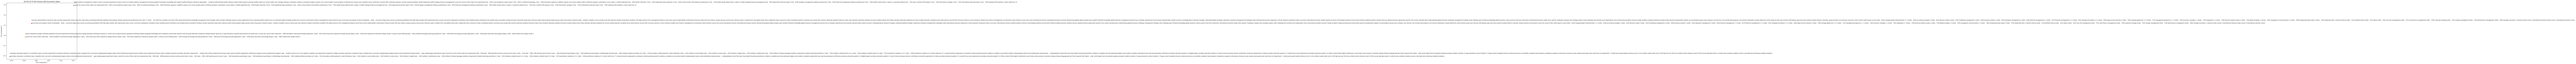

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random

# Assuming `documents` is a pre-defined list of document strings.
# Example documents (replace with actual content)

# Ensure we have more than one document for PCA
if len(documents) > 1:
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=10000, min_df=2, stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(documents)

    # Check that we have more than one feature to perform PCA
    if tfidf_matrix.shape[1] > 1:
        # PCA for dimensionality reduction
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(tfidf_matrix.toarray())

        # Select a random sample of document indices to plot
        # Replace '4' with 'len(documents)' to plot all
        selected_indices = random.sample(range(len(documents)), 4)
        selected_data = reduced_data[selected_indices]
        selected_document_names = [documents[i] for i in selected_indices]

        # Plot
        plt.figure(figsize=(10, 8))
        for i, document_name in enumerate(selected_document_names):
            plt.scatter(selected_data[i, 0], selected_data[i, 1])
            plt.text(selected_data[i, 0], selected_data[i, 1], document_name)

        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title('2D PCA of TF-IDF Vectors with Document Labels')
        plt.show()
    else:
        print("TF-IDF vectorization resulted in less than two features. Cannot perform PCA.")
else:
    print("Need at least two documents to perform PCA.")


**Trying Another embedding method using openai embeddings**

In [9]:
import chromadb
import faiss
CHROMA_PATH = "chroma"

In [8]:
import chromadb.utils.embedding_functions as embedding_functions
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=openai_api_key,
                model_name="text-embedding-3-small"
            )


def generate_embeddings(documents):
    """Generate embeddings for a list of documents using OpenAI's API."""
    # Processing documents in batches to avoid hitting API limits
    embeddings = []
    batch_size = 20  # Define a suitable batch size based on your API usage plan
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i+batch_size]
        batch_embeddings = np.array(openai_ef(batch))
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

In [12]:
document_embeddings = generate_embeddings(chunked_docs)

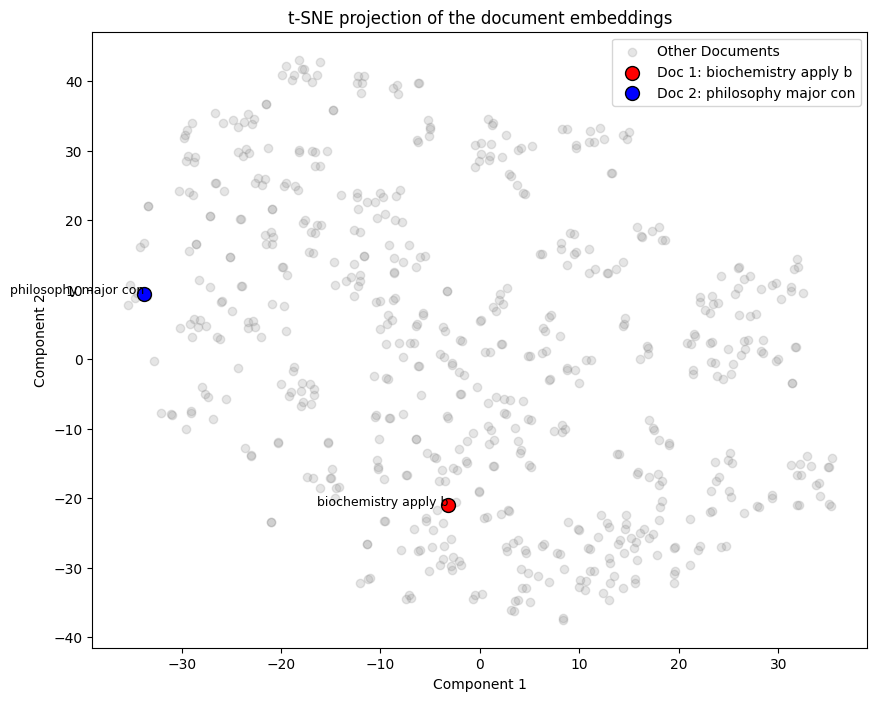

In [133]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assume document_embeddings is your embeddings array
# Reducing dimensions to 2 for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(document_embeddings)

# Plotting
plt.figure(figsize=(10, 8))

# Scatter plot for all documents (minimize visibility of others)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.2, color='grey', label='Other Documents')

# Highlight the first and second documents
# Using the first 20 characters from each document as the label
doc1_label = chunked_docs[0][:20]  # First 20 characters of the first document
doc2_label = chunked_docs[1][:20]  # First 20 characters of the second document

plt.scatter(embeddings_2d[0, 0], embeddings_2d[0, 1], color='red', edgecolor='k', s=100, label=f'Doc 1: {doc1_label}')
plt.scatter(embeddings_2d[1, 0], embeddings_2d[1, 1], color='blue', edgecolor='k', s=100, label=f'Doc 2: {doc2_label}')

# Adding labels to the points
plt.text(embeddings_2d[0, 0], embeddings_2d[0, 1], doc1_label, fontsize=9, ha='right')
plt.text(embeddings_2d[1, 0], embeddings_2d[1, 1], doc2_label, fontsize=9, ha='right')

plt.title('t-SNE projection of the document embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()


In [66]:
import faiss

def create_faiss_index(embeddings):
    """Create a FAISS index for the given embeddings."""
    dimension = embeddings.shape[1]  # Dimension of the embeddings
    index = faiss.IndexFlatL2(dimension)  # Using L2 distance for similarity
    index.add(embeddings)  # Add embeddings to the index
    return index

# Create the index
index = create_faiss_index(document_embeddings)

In [76]:
def search(query_embedding, index, top_k=5):
    """Search for the top_k nearest neighbors of the given query_embedding."""
    distances, indices = index.search(query_embedding.reshape(1, -1), top_k)  # Reshape query to (1, dimension)
    return distances, indices


In [77]:
query_embedding = generate_embeddings(["Computer science certificate"])


In [78]:
distances, result_indices = search(query_embedding, index, top_k = 10)

In [88]:

distances[0][1]

0.7911726

In [73]:
import re

def get_first_sentence(text):
    return text[:100]
    


In [89]:

def print_results(docs, result_indices, distances):
    for idx_array in result_indices:
        i = 0
        for idx in idx_array:
            if idx < len(docs):  # Check if the index is within the range of available documents
                document_text = docs[idx]  # Retrieve the document text by index
                first_sentence = get_first_sentence(document_text)  # Extract the first sentence
                print(f"Document {idx} Distance: {distances[0][i]} first sentence: {first_sentence}")
            else:
                print(f"Index {idx} out of range. Total documents: {len(docs)}")
            i += 1

\

In [90]:
print_results(chunked_docs, result_indices, distances)

Document 604 Distance: 0.5756227970123291 first sentence: computer science certificate overview requirement undergraduate certificate computer science offer s
Document 99 Distance: 0.7911726236343384 first sentence: cyber technology certificate graduate overview requirement cyber technology graduate certificate 18 
Document 489 Distance: 0.8278151750564575 first sentence: cyber defense certificate graduate overview requirement graduate certificate credit course study stu
Document 592 Distance: 0.8407032489776611 first sentence: computational engineering certificate overview requirement engineering physics major opportunity foc
Document 424 Distance: 0.849085807800293 first sentence: technology architecture certificate graduate overview requirement graduate certificate credit course
Document 130 Distance: 0.8647997975349426 first sentence: cyber leadership certificate graduate overview requirement graduate certificate credit course study 
Document 486 Distance: 0.8767645359039307 first 

The text contains 9 tokens.
